# Etude de cas QUBO

Ici, nous allons étudier la résolution de matrice QUBO grâce à pile logicielle de Pasqal, comparé à la résolution classique.

## Génération de QUBO
Nous utilisons la bibliothèque qubogen pour générer des matrices QUBO de manière aléatoire.

In [25]:
import qubogen
import numpy as np

# np.set_printoptions(threshold=np.inf) Si la matrice est trop grande pour être affichée

In [26]:
size =  4 # taille de la matrice

In [27]:
np.random.seed(5) # pour reproduire les résultats
s = np.random.randint(1,10,size, dtype=int)

In [28]:
Q = qubogen.qubo_number_partition(s)
Q

array([[-60,  28,  28,   4],
       [ 28, -84,  49,   7],
       [ 28,  49, -84,   7],
       [  4,   7,   7, -18]])

## Résolution via Pasqal
Ce tutoriel est inspiré de la documentation Pasqal ["QAOA and QAA to solve a QUBO problem"](https://pulser.readthedocs.io/en/stable/tutorials/qubo.html)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

In [30]:
def evaluate_mapping(new_coords, *args):
    """Cost function to minimize. Ideally, the pairwise
    distances are conserved"""
    Q, shape = args
    new_coords = np.reshape(new_coords, shape)
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

In [31]:
# Création du registre atomique pour placer les qubits
# La fonction evaluate_mapping permet de trouver la position optimal des 
# atomes dans le registre et qui réplique au mieux les termes de la diagonale de Q
shape = (len(Q), 2)
costs = []
np.random.seed(5)
x0 = np.random.random(shape).flatten()
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q, shape),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))
qubits = dict(enumerate(coords))
reg = Register(qubits)

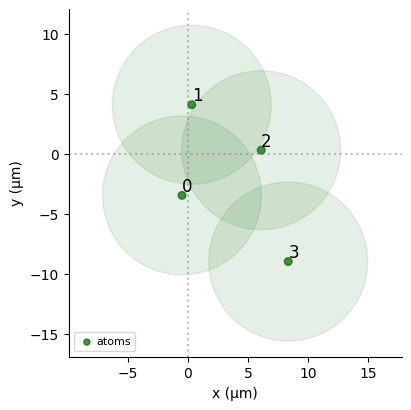

In [32]:
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

## Création de la séquence d'impulsion

In [33]:
def quantum_loop(parameters):

    params = np.array(parameters, dtype=int).reshape(2, LAYERS)
    t_params, s_params = params
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    
    # Initialisation et exécution de la simulation
    simul = QutipEmulator.from_sequence(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    
    # Échantillonnage de l'état final
    count_dict = results.sample_final_state()  # sample from the state vector
    
    return count_dict

def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost

def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

def func(param, *args):
    Q = args[0]
    C = quantum_loop(param)
    cost = get_cost(C, Q)
    return cost

In [34]:
LAYERS = 2
# Création de la séquence d'impulsions
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ch0", "rydberg_global")

t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)

for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")

np.random.seed() #seed randomizer
guess = {
    "t": np.random.uniform(8, 10, LAYERS),
    "s": np.random.uniform(1, 3, LAYERS),
}

example_dict = quantum_loop(np.r_[guess["t"], guess["s"]])

Nous avons parralélisé le processus afin d'augmenter la vitesse de résolution

In [35]:
from joblib import Parallel, delayed

In [36]:
def perform_minimization(guess, Q):
    try:
        res = minimize(
            func,
            args=Q,
            x0=np.r_[guess["t"], guess["s"]],
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 30},
        )
        return res.fun, res.x
    except Exception as e:
        return None, None

In [37]:
print("Entrée dans la minimisation, cela peut prendre du temps (< 3 minutes)")

n_jobs = -1
results = Parallel(n_jobs=n_jobs)(
    delayed(perform_minimization)(
        {"t": np.random.uniform(1, 10, LAYERS), "s": np.random.uniform(1, 10, LAYERS)},
        Q
    ) for _ in range(20)
)

results = [(score, param) for score, param in results if score is not None]

scores, params = zip(*results)

optimal_count_dict = quantum_loop(params[np.argmin(scores)])

Entrée dans la minimisation, cela peut prendre du temps (< 3 minutes)


In [38]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    plt.figure(figsize=(24, 12))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5)
    plt.xticks(rotation="vertical")
    plt.show()

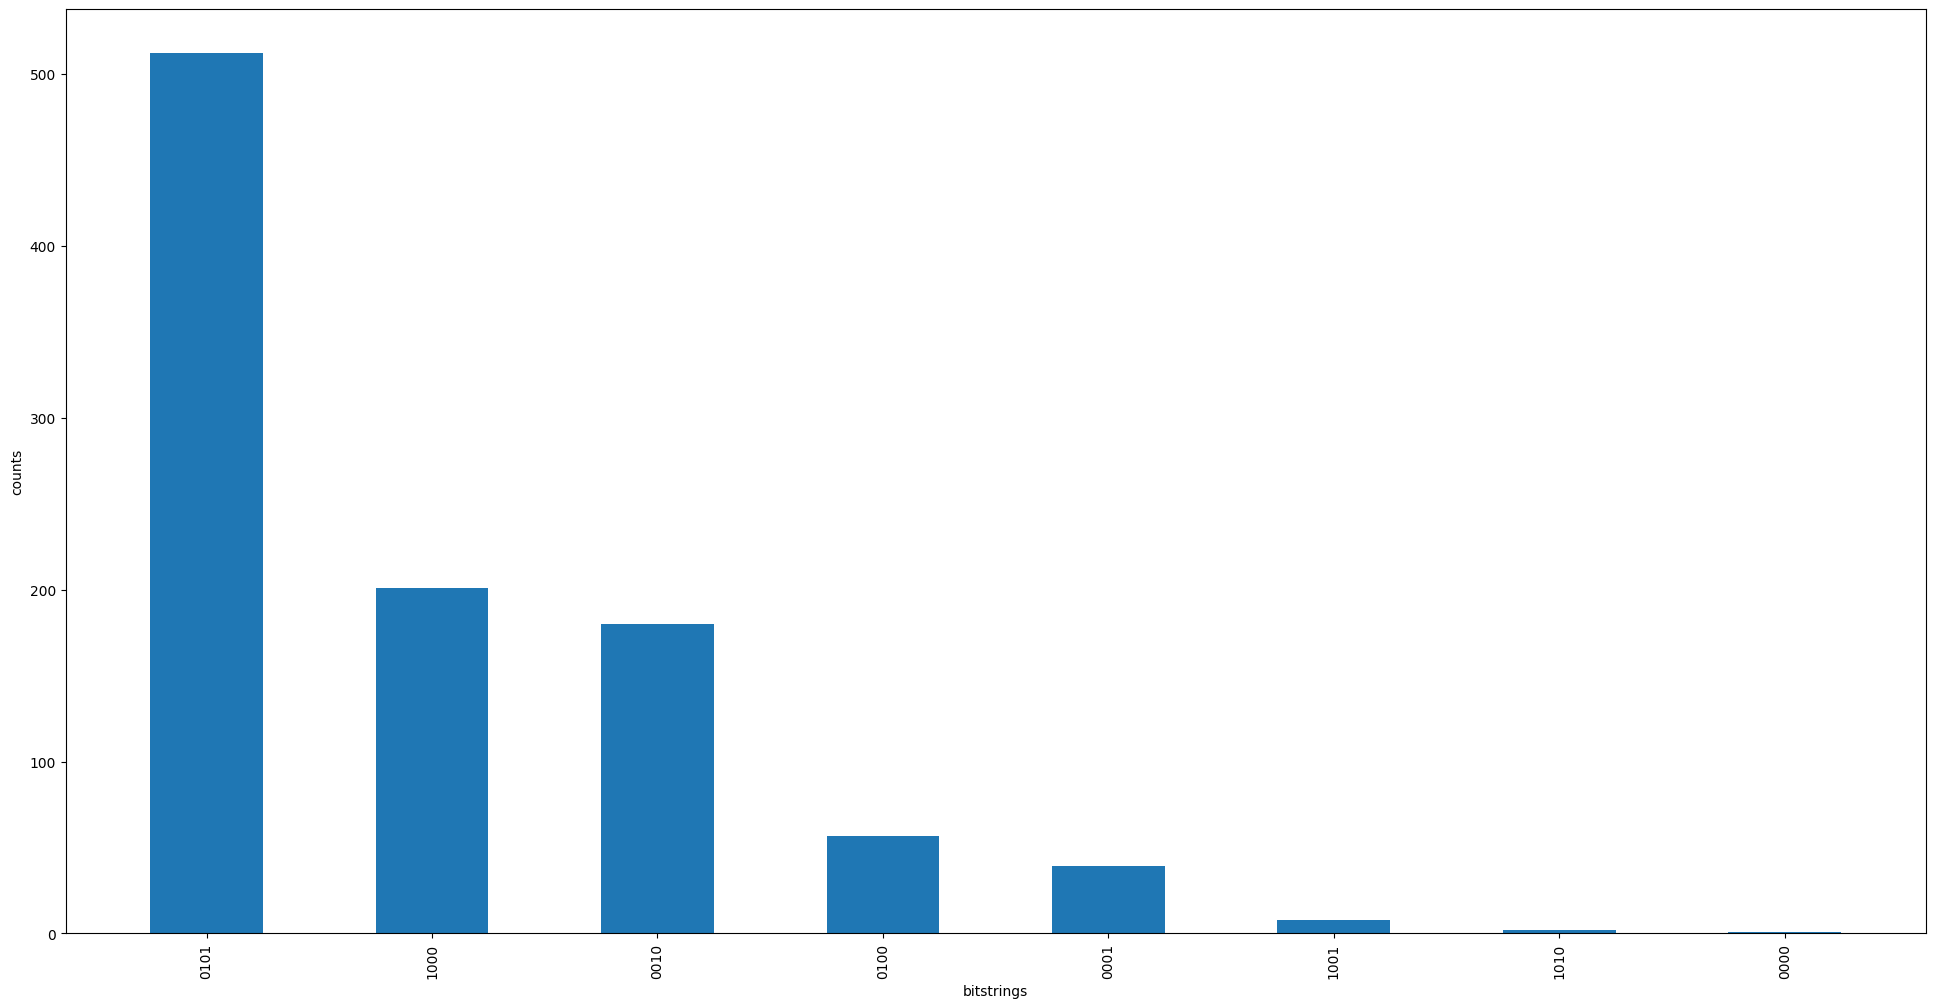

In [39]:
optimal_count_dict = quantum_loop(params[np.argmin(scores)])
optimal_binary_string = max(optimal_count_dict, key=optimal_count_dict.get)
plot_distribution(optimal_count_dict)

In [40]:
optimal_binary_string

'0101'

In [41]:
z = np.array(list(optimal_binary_string), dtype=int)

In [42]:
def calculate_cost(Q, z):
    return z.T @ Q @ z

In [43]:
calculate_cost(Q, z)

-88

Nous avons trouvé -88 comme énergie du résultat. Vérifions si ce résultat fais parti des 10% meilleurs résultats possibles.

L'émulation de la machine Pasqal ressort la valeur 10 comme meilleur résultat. Ce dernier restant probabiliste, nous pouvons, à cette échelle, comparer avec un vrai résultat trouvé classiquement ci-dessous.

In [44]:
from qubolite import qubo
from qubolite.solving import local_descent

In [45]:
Q = qubo(Q)
Q

qubo([[-60,  56,  56,   8],
       [  0, -84,  98,  14],
       [  0,   0, -84,  14],
       [  0,   0,   0, -18]])

In [46]:
x = np.random.random(size) < 0.5

In [47]:
optimal_vector, optimal_energy = local_descent(Q, x)

In [48]:
optimal_energy

-88

Nous venons de vérifier le résultat trouvé classiquement grâce à la méthode de descente du gradient, avec une énergie de -88.
Le coût minimal trouvé par le QAOA est également -88, nous avons donc le meilleur résultat.